# Problem Set 01 : Geometric Image Formation

Computer Vision (CSE 559a)

Name: Daniel Cher

## Overview

This problem set includes a small set of coding exercises related to geometric image formation.

## Helpful Hints

- `<Control>-Enter` will run the selected cell.
- `<Shift>-Enter` will run the selected cell, and move to the next cell.

# Setup

Here we import a few useful libraries and define some helper functions

In [ ]:
# for colab user
# if 'google.colab' in str(get_ipython()):
#   !pip install nptyping

In [134]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage.io import imread

from nptyping import NDArray, Float, Shape, assert_isinstance

# set a little nicer default for printing floating point numbers
np.set_printoptions(precision=2, suppress=True)

def setup_axis(lims=[-1,1]):
  plt.figure(); fig = plt.figure(); ax = plt.axes(projection='3d')
  ax.set_xlim(*lims); ax.set_ylim(*lims); ax.set_zlim(*lims)
  return ax


def draw_line(abc,color='k',ylim=(0,427),xlim=(0,640)):
  # draw a line in the form abc (i.e., line satisfying ax+by+c = 0)
  # there are more efficient ways to do this, but this makes the constraint very clear

  # adapted from David Fouhey

  # HACK the xlim and ylim are hard coded for the size of the example image

  a,b,c = abc[0], abc[1], abc[2]

  # https://stackoverflow.com/questions/14000595/graphing-an-equation-with-matplotlib
  # http://courses.csail.mit.edu/6.867/wiki/images/3/3f/Plot-python.pdf
  xlist = np.linspace(xlim[0], xlim[1], 500) # Create 1-D arrays for x,y dimensions
  ylist = np.linspace(ylim[0], ylim[1], 150) 
  X,Y = np.meshgrid(xlist, ylist) # Create 2-D grid xlist,ylist values
  F = a*X + b*Y + c

  plt.contour(X, Y, F, [0], colors = color, linestyles = 'solid', linewidths=[4])

def make_homogenous(a, b) -> NDArray[Shape["3,1"], Float]:
  tmp = np.array([a,b,1], dtype=float).reshape((3,1))
  return tmp


# Cross Products

In homogenous coordinates, we can estimate the parameters of a line by taking the cross product of a pair of points, $l = p_1 \times p_2$, and vice versa, $p = l_1 \times l_2$. Here we visualize the relationship between between the vectors that represent the parameters. Note that while they don't appear orthogonal in the visualization, they are in reality.

R1 is orthogonal to r1 x r2: True
R2 is orthogonal to r1 x r2: True


<Figure size 640x480 with 0 Axes>

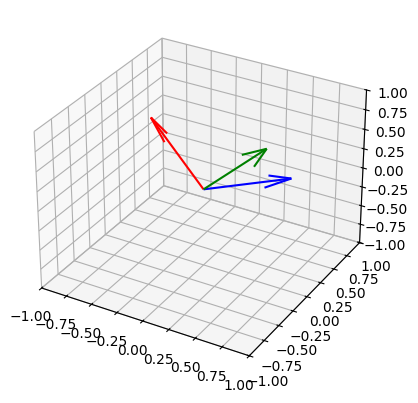

In [3]:

# make two random column vectors
r1 = np.random.randn(3,1)
r1 = r1 / np.linalg.norm(r1)
r2 = np.random.randn(3,1)
r2 = r2 / np.linalg.norm(r2)

# compute their cross product
# (we need the transposes because `np.cross` expects row vectors)
r1_x_r2 = np.cross(r1.T, r2.T).T

# plot the vectors

ax = setup_axis()
ax.quiver3D(0,0,0,r1[0], r1[1], r1[2],colors='r')
ax.quiver3D(0,0,0,r2[0], r2[1], r2[2],colors='g')
ax.quiver3D(0,0,0,r1_x_r2[0], r1_x_r2[1], r1_x_r2[2],colors='b')

# they may not look entirely at right angles (because of Matplotlib plotting), 
# but it's easy to verify that they are orthogonal 

print(f'R1 is orthogonal to r1 x r2: {np.allclose(r1_x_r2.T @ r1, 0)}')
print(f'R2 is orthogonal to r1 x r2: {np.allclose(r1_x_r2.T @ r2, 0)}')


## Using cross products to demonstrate that vectors define a plane

Here we select a fixed vector and compute its cross product with a large number of random vectors. Note that these all end up on the plane that is orthogonal to the initial vector.

<Figure size 640x480 with 0 Axes>

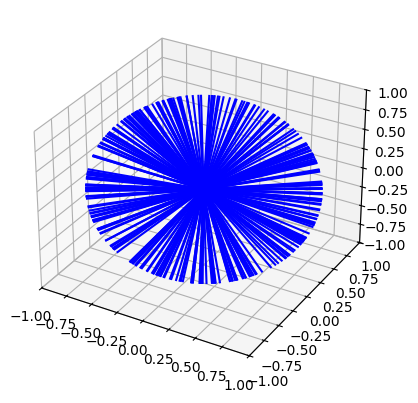

In [4]:

vec_1 = np.random.randn(3,1)
vec_1 = vec_1 / np.linalg.norm(vec_1)
vecs_2 = np.random.randn(3,300)
vecs_2 = vecs_2 / np.linalg.norm(vecs_2, axis=0, keepdims=True)

 # compute cross products
crosses = np.cross(vec_1, vecs_2, axis=0)

# normalize vectors. compute magnitude of each vector and divide by it
crosses_unit = crosses / np.sqrt(np.sum( crosses**2, axis=0, keepdims=True))

# visualizing the main vector (red) with the vectors (blue) that result from the 
# cross product between the main vector and other random vectors
#
# Notice that the blue vectors are co-planar (you may need to run this multiple times to convince yourself)

ax = setup_axis()
ax.quiver3D(0,0,0,crosses_unit[0,:], crosses_unit[1,:], crosses_unit[2,:], color='b', arrow_length_ratio=0)
ax.quiver3D(0,0,0,vec_1[0,:], vec_1[1,:], vec_1[2,:],color='r')


## Replacing `np.cross` with the cross product matrix

While `np.cross` is a convenient way to compute the cross product, it can be cumbersome at times. Here's a simple way to compute the cross product matrix. Notice that multiplying by that matrix generates the same output as calling `np.cross`.

In [5]:

def cross_product_matrix(vec: NDArray[Shape["3,1"], Float]) -> NDArray[Shape["3,3"], Float]:
  """
  compute the cross product matrix for a given vector
  """
  
  # you could form this manually, here's a shortcut

  return np.cross(vec, np.identity(vec.shape[0]), axis=0)

# compute the cross product
crosses_via_matrix = cross_product_matrix(vec_1) @ vecs_2

# Verify that both ways compute the same value

np.allclose(crosses, crosses_via_matrix)


True

## TASK : Use `numpy.linalg.lstsq` to solve for the cross product matrix for a vector, `vec_1 = [3,4,5]`.

Create a function that uses a least squares solver to determine the matrix that corresponds to the cross product operation for a given vector. This is not how you would create such a matrix in practice (see above for the easy way), since it's a deterministic mapping from the vector to the matrix. However, this exercise should make it clear how the pieces fit together and be good practice solving a least squares system in Python.

### Least Squares Background

Least squares can be used to solve over constrained linear systems, and is frequently used in geometric computer vision applications. In the single-output setting setting, we are given $A$ and $b$ and assume they are related to some unknown parameters as follows: $A \theta = b$. In this case, we actually have a multiple output case, $A \Theta = B$, but that doesn't change much in practice. In this case, $\Theta$ will correspond to our cross product matrix.

### Suggestions:

1. Create a array with a large number of random column vectors, say 30 (`np.random.randn` should work well).
2. Compute the cross product of all of those vectors with `vec_1`.
3. Write out the linear equation that would relate the your random matrix and the matrix of cross products.
4. Use `numpy.linalg.lstsq` to solve for the cross product matrix. Note that it takes parameters $A$ and $B$, which correspond to the matrices described in the Least Squares Background section.
5. Probably the most tricky part of this exercise is making sure you have the matrices transposed correctly. It's often useful to write out the generative model for the system (in this case the matrix multiply that generates the cross product matrix), ensure the dimensions are correct, and then convert it into the form that is expected by the library.

In [28]:
np.random.randn(3,30).shape

(3, 30)

In [31]:
vec_1 = np.asarray([3.,4.,5.]).reshape((3,1))

def cross_product_matrix_lst(vec: NDArray[Shape["3,1"], Float]) -> NDArray[Shape["3,3"], Float]:
  ### YOUR CODE BELOW HERE

  # create an array with large number of random vectors
  vecs = np.random.randn(3,30)

  # compute cross products
  crosses = np.cross(vec, vecs, axis=0)

  # C_T * u_i = (v x u_i)

  # 4. Use `numpy.linalg.lstsq` to solve for the cross product matrix. Note that it takes parameters $A$ and $B$, which correspond to the matrices described in the Least Squares Background section.
  x = np.linalg.lstsq(vecs.T, crosses.T, rcond=None)[0]

  # transpose
  x = x.T

  ### YOUR CODE ABOVE HERE
  return x

print(f"My function returns : \n {cross_product_matrix_lst(vec_1)}")
print(f"The direct function returns : \n {cross_product_matrix(vec_1)}")

print(f"These functions the same thing : {np.allclose(cross_product_matrix_lst(vec_1), cross_product_matrix(vec_1))}")


My function returns : 
 [[-0. -5.  4.]
 [ 5.  0. -3.]
 [-4.  3.  0.]]
The direct function returns : 
 [[ 0. -5.  4.]
 [ 5.  0. -3.]
 [-4.  3.  0.]]
These functions the same thing : True


# Homogeneous Lines and Points

Vanishing points and horizon lines are useful geometric objects for a variety of reasons. In this exercise, we manipulate them in image coordinates. We'll first show how to load an image, plot a few points, and the display the lines corresponding to pairs of points. There are a number of ways to plot homogenous lines. We provide an example of one way to accomplish this. It's not the most efficient way, but you may find it instructive. 

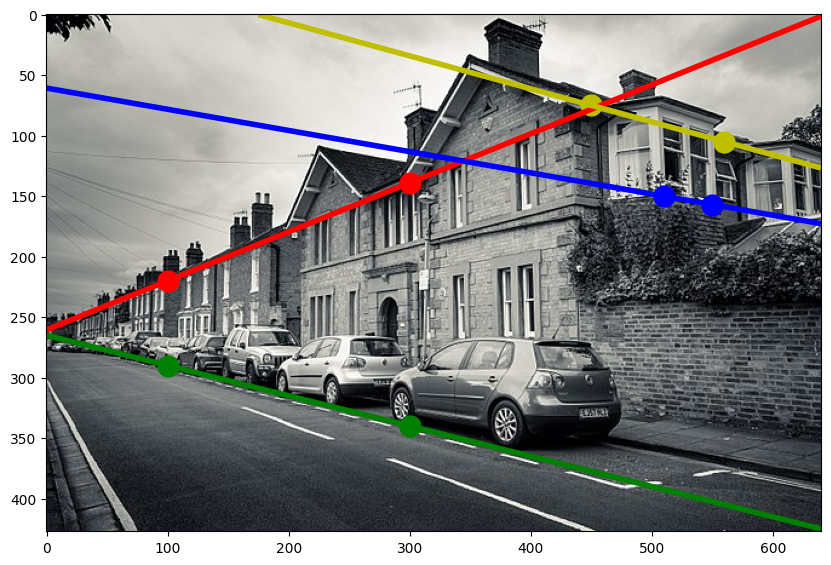

In [32]:
# load an image
im = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/College_Street_%289268126660%29.jpg/640px-College_Street_%289268126660%29.jpg')

# define some points that correspond to apparently parallel lines in the world
pts_r = [
    [300,139],
    [100,220]
    ]

pts_g = [
    [300,340],
    [100,290]
    ]

pts_y = [
    [450,75],
    [560,105]
    ]

pts_b = [
    [510,150],
    [550,157]
    ]

#
# plot the points, the lines, and the horizon line
#

plt.figure(figsize=(10,8))
plt.imshow(im)

# plot the points
plt.plot(*pts_r[0], 'o', color='r', markersize=15)
plt.plot(*pts_r[1], 'o', color='r', markersize=15)

plt.plot(*pts_g[0], 'o', color='g', markersize=15)
plt.plot(*pts_g[1], 'o', color='g', markersize=15)

plt.plot(*pts_y[0], 'o', color='y', markersize=15)
plt.plot(*pts_y[1], 'o', color='y', markersize=15)

plt.plot(*pts_b[0], 'o', color='b', markersize=15)
plt.plot(*pts_b[1], 'o', color='b', markersize=15)

# use the points to compute the lines
line_r = np.cross(make_homogenous(*pts_r[0]), make_homogenous(*pts_r[1]), axis=0)
line_g = np.cross(make_homogenous(*pts_g[0]), make_homogenous(*pts_g[1]), axis=0)
line_y = np.cross(make_homogenous(*pts_y[0]), make_homogenous(*pts_y[1]), axis=0)
line_b = np.cross(make_homogenous(*pts_b[0]), make_homogenous(*pts_b[1]), axis=0)

# draw the lines
draw_line(line_r, color='r')
draw_line(line_g, color='g')
draw_line(line_y, color='y')
draw_line(line_b, color='b')



## TASK plot the horizon line

Compute the parameters of the horizon line and assign to a variable `line_horiz` Assume that the red and green lines are parallel and that the yellow and blue lines are parallel. 



_Points:_ 15

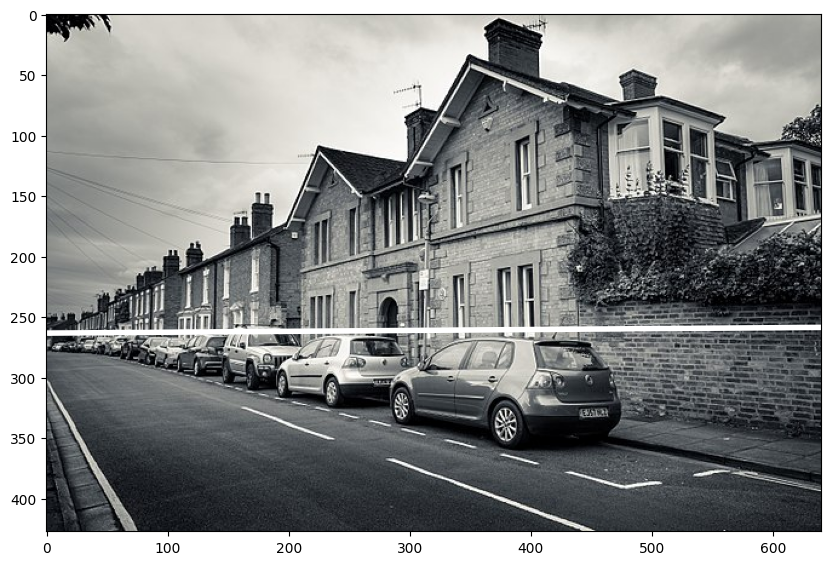

In [35]:

plt.figure(figsize=(10,8))
plt.imshow(im)

def compute_horizon_line(
    line_a_1: NDArray[Shape["3,1"], Float],
    line_a_2: NDArray[Shape["3,1"], Float], 
    line_b_1: NDArray[Shape["3,1"], Float],
    line_b_2: NDArray[Shape["3,1"], Float]) -> NDArray[Shape["3,1"], Float]:
  """
  compute_horizon_line 

  line_a_1 and line_a_2 are the homogenous coordinates for two parallel lines
  line_b_1 and line_b_2 are the homogenous coordinates for two parallel lines

  """
  ### YOUR CODE BELOW HERE

  # calculate vanishing points. Reshape lines into 1D arrays
  vanishing_point_a = np.cross(line_a_1.flatten(), line_a_2.flatten())
  vanishing_point_b = np.cross(line_b_1.flatten(), line_b_2.flatten())

  # caclulate the horizon line
  line = np.cross(vanishing_point_a, vanishing_point_b)

  # normalize the line
  line = line / np.linalg.norm(line)
  ### YOUR CODE ABOVE HERE

  return line

line_horiz = compute_horizon_line(line_r, line_g, line_y, line_b)

# draw the horizon line defined in `line_horiz`
draw_line(line_horiz, color='w')

# Calibration Matrices and Orthogonal Vanishing

The camera calibration matrix, $K$, also called the intrinsic matrix, defines the mapping between locations in the world, $X$ ($3D$ homogenous), and a location in the image, $p$ ($2D$ homogenous). 

For this exercise, you will assume that the extrinsic rotation matrix is the identity, $R=I$, and that the extrinsic camera translation is zeros. We will also assume that the world coordinates we are handling are actually vanishing points. This means that their last element of $X$ is zero, since they are points at infinity. These assumptions leads to the following form of the camera projection matrix, $p = K[R | t] X = KX$.

## Given: 

- two directions in the world that correspond to the vanishing points of orthogonal lines. You can think of these as the vanishing points of the faces of a cube. These are in the columns of `X_orth`.
- the image location, represented as 2D homogenous coordinates, in the columns of `P_image`.

In [182]:
# the world directions that are orthgonal
X_orth = np.array([[ 0.7813,  0.3877],
 [-0.4809,  0.8735],
 [ 0.3978,  0.2945]])

# the image coordinates of those points
P_image = np.array([[ 5.8914,  3.9493],
 [-3.6265,  8.8975],
 [ 1.    ,  1.    ]])

## TASK estimate the focal length for a simple camera

Assume the intrinsic camera matrix has the form `K = np.array([[f,0,0],[0,f,0],[0,0,1]])`, what was focal length, `f`, of the camera? Justify your answer by showing the image coordinates that the correspond to the image locations with your estimated focal length.

Hint: the focal length is a small integer.

_Points:_ 15

In [193]:

print("True Image Coordinates")
print(P_image)

def project_into_image(f: float, X_orth: NDArray[Shape["3,2"], Float]) -> NDArray[Shape["3,2"], Float]:
  ### YOUR CODE BELOW HERE
  
  K = np.array([[f,0,0],[0,f,0],[0,0,1]])

  # Project each direction using K
  projected = K @ X_orth

  # Homogenize by dividing each column by its third component
  P_image_est = projected / projected[2, :]

  return P_image_est

# provide your estimated focal length: f = ?
# compute focal length using the unit point
# f_x = x * Z / X --> Z = 1 due to homogenous coordinates
f_x = P_image[2, 0] / X_orth[2,0]
# f_y = y * Z / Y
f_y = P_image[2, 1] / X_orth[2,1]
# Average to get estimate
f = round(np.mean([f_x, f_y]))

P_image_est = project_into_image(f, X_orth)

print("\nPredicted Image Coordinates")
print(P_image_est)

print("\nAre the Predicted Image Coordinates Close Enough?")
print(np.allclose(P_image_est, P_image, rtol=.01))

True Image Coordinates
[[ 5.89  3.95]
 [-3.63  8.9 ]
 [ 1.    1.  ]]

Predicted Image Coordinates
[[ 5.89  3.95]
 [-3.63  8.9 ]
 [ 1.    1.  ]]

Are the Predicted Image Coordinates Close Enough?
True


# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]

I used github copilot and verified outputs for some of the problems in some parts.